In [2]:
from dmc2gymnasium import DMCGym
from synther.diffusion.utils import make_inputs
from dm_control import suite
from tqdm import trange

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
def plt_distribution(obs, reward, title, range):
    fig, axes = plt.subplots(2, 3, figsize=(15, 5))

    fig.suptitle(title, fontsize=16)

    sns.histplot(obs[:range, 0], kde=True, ax=axes[0, 0])
    axes[0, 0].set_title('Pos 1')
    axes[0, 0].set_xlabel('Value')
    axes[0, 0].set_ylabel('Frequency')

    sns.histplot(obs[:range, 1], kde=True, ax=axes[0, 1])
    axes[0, 1].set_title('Pos 2')
    axes[0, 1].set_xlabel('Value')
    axes[0, 1].set_ylabel('Frequency')

    sns.histplot(obs[:range, 2], kde=True, ax=axes[0, 2])
    axes[0, 2].set_title('Pos 3')
    axes[0, 2].set_xlabel('Value')
    axes[0, 2].set_ylabel('Frequency')

    sns.histplot(obs[:range, 3], kde=True, ax=axes[1, 0])
    axes[1, 0].set_title('Vel 1')
    axes[1, 0].set_xlabel('Value')
    axes[1, 0].set_ylabel('Frequency')

    sns.histplot(obs[:range, 4], kde=True, ax=axes[1, 1])
    axes[1, 1].set_title('Vel 2')
    axes[1, 1].set_xlabel('Value')
    axes[1, 1].set_ylabel('Frequency')

    sns.histplot(reward[:range], kde=True, ax=axes[1, 2])
    axes[1, 2].set_title('Reward')
    axes[1, 2].set_xlabel('Value')
    axes[1, 2].set_ylabel('Frequency')

    plt.tight_layout()

    plt.show()

In [4]:
def _flatten_obs(obs, dtype=np.float32):
    obs_pieces = []
    for v in obs.values():
        flat = np.array([v]) if np.isscalar(v) else v.ravel()
        obs_pieces.append(flat)
    return np.concatenate(obs_pieces, axis=0).astype(dtype)

def reset_to_state(env, state):
    env._reset_next_step = False
    env._step_count = 0
    with env._physics.reset_context():
        env._physics.named.data.qpos[:] = np.array([state[0], state[1]])
        env._physics.named.data.qvel[:] = np.array([state[2], state[3]])
    env._task.after_step(env._physics)
    
def calculate_diffusion_loss(diffusion_dataset, env, range = None):
    if range is None:
        range = diffusion_dataset["observations"].shape[0]
    reward_loss = np.zeros((range, 1))
    observation_loss = np.zeros((range, diffusion_dataset["observations"].shape[1]))

    # for transition in trange(diffusion_dataset["observations"].shape[0]):
    for transition in trange(range):
        index = np.ones(diffusion_dataset["observations"].shape[1], dtype=bool)
        index[2] = False
        observation = diffusion_dataset["observations"][transition]
        state = observation[index]
        # state[1] = np.arccos(state[1].clip(-1, 1))
        state[1] = np.arctan2(observation[2], observation[1])
        action = diffusion_dataset["actions"][transition]
        reward = diffusion_dataset["rewards"][transition]
        next_observation = diffusion_dataset["next_observations"][transition]

        # if transition == 0:
        #     print(observation, action, reward, next_observation)
        reset_to_state(env, state)
        timestamp = env.step(action)
        reward_true = timestamp.reward
        next_observation_true = _flatten_obs(timestamp.observation)
        reward_loss[transition, :] = np.abs(reward - reward_true)
        observation_loss[transition, :] = np.abs(next_observation - next_observation_true)
    return observation_loss, reward_loss

def filter_data(loss, percentile):
    pos1_percentile = np.percentile(loss[:, 0], percentile)

    pos2_percentile = np.percentile(loss[:, 1], percentile)

    pos3_percentile = np.percentile(loss[:, 2], percentile)

    vel1_percentile = np.percentile(loss[:, 3], percentile)

    vel2_percentile = np.percentile(loss[:, 4], percentile)

    reward_percentile = np.percentile(loss[:, 5], percentile)

    filtered_out_indices = np.where((loss[:, 0] > pos1_percentile) | 
                                     (loss[:, 1] > pos2_percentile) |
                                     (loss[:, 2] > pos3_percentile) |
                                        (loss[:, 3] > vel1_percentile) |
                                        (loss[:, 4] > vel2_percentile) |
                                        (loss[:, 5] > reward_percentile))[0]
    indices = np.where((loss[:, 0] <= pos1_percentile) &
                                     (loss[:, 1] <= pos2_percentile) &
                                     (loss[:, 2] <= pos3_percentile) &
                                        (loss[:, 3] <= vel1_percentile) &
                                        (loss[:, 4] <= vel2_percentile) &
                                        (loss[:, 5] <= reward_percentile))[0]
    # indices = np.where((loss[:, 0] <= 0.005) &
    #                                  (loss[:, 1] <= 0.005) &
    #                                  (loss[:, 2] <= 0.005) &
    #                                     (loss[:, 3] <= 0.01) &
    #                                     (loss[:, 4] <= 0.01) &
    #                                     (loss[:, 5] <= 0.001))[0]
    return filtered_out_indices, indices

In [5]:
def filter_by_boundary(training_dataset, diffusion_dataset):
    indices = np.arange(0,diffusion_dataset["observations"].shape[0])
    for key in diffusion_dataset.keys():
        if (key == "observations") | (key == "next_observations"):
            boundary_Pos1 = (training_dataset[key][:,0].min(), training_dataset[key][:,0].max())
            boundary_Pos2 = (training_dataset[key][:,1].min(), training_dataset[key][:,1].max())
            boundary_Pos3 = (training_dataset[key][:,2].min(), training_dataset[key][:,2].max())
            boundary_Vel1 = (training_dataset[key][:,3].min(), training_dataset[key][:,3].max())
            boundary_Vel2 = (training_dataset[key][:,4].min(), training_dataset[key][:,4].max())
            
            filtered_indices = np.where(((diffusion_dataset[key][:,0] >= boundary_Pos1[0]) & (diffusion_dataset[key][:,0] <= boundary_Pos1[1])) &
                                ((diffusion_dataset[key][:,1] >= boundary_Pos2[0]) & (diffusion_dataset[key][:,1] <= boundary_Pos2[1])) &
                                ((diffusion_dataset[key][:,2] >= boundary_Pos3[0]) & (diffusion_dataset[key][:,2] <= boundary_Pos3[1])) &
                                ((diffusion_dataset[key][:,3] >= boundary_Vel1[0]) & (diffusion_dataset[key][:,3] <= boundary_Vel1[1])) &
                                ((diffusion_dataset[key][:,4] >= boundary_Vel2[0]) & (diffusion_dataset[key][:,4] <= boundary_Vel2[1])))[0]
            
        else:
            boundary = (training_dataset[key].min(), training_dataset[key].max())
            filtered_indices = np.where((diffusion_dataset[key] >= boundary[0]) & (diffusion_dataset[key] <= boundary[1]))[0]
        
        indices = np.intersect1d(indices, filtered_indices)
        full_indices = np.arange(0,diffusion_dataset["observations"].shape[0])
        filtered_out_indices = np.setdiff1d(full_indices, indices)
    
    return {key: diffusion_dataset[key][indices] for key in diffusion_dataset.keys()}, {key: diffusion_dataset[key][filtered_out_indices] for key in diffusion_dataset.keys()}
            
        
    

In [6]:
def statistic(diffusion_dataset):
    for key in diffusion_dataset.keys():
        if key == "observations":
            print("Pos1", diffusion_dataset[key][:,0].min(), diffusion_dataset[key][:,0].max())
            print("Pos2", diffusion_dataset[key][:,1].min(), diffusion_dataset[key][:,1].max())
            print("Pos3", diffusion_dataset[key][:,2].min(), diffusion_dataset[key][:,2].max())
            print("Vel1", diffusion_dataset[key][:,3].min(), diffusion_dataset[key][:,3].max())
            print("Vel2", diffusion_dataset[key][:,4].min(), diffusion_dataset[key][:,4].max())
        elif key != "next_observations":
            print(key, diffusion_dataset[key].min(), diffusion_dataset[key].max())

In [7]:
env = suite.load(domain_name="cartpole", task_name="swingup")

In [11]:
training_dataset = make_inputs("dm-cartpole-train-length-all-v0", context=False, uniform=False, segment=None)

In [13]:
import torch
import pathlib
from torch.utils.data import random_split

# 创建输入数据
inputs = training_dataset
inputs = torch.from_numpy(inputs).float()
dataset = torch.utils.data.TensorDataset(inputs)

# 划分数据集
train_size = int(0.8 * len(dataset))  # 80% 用于训练
test_size = len(dataset) - train_size  # 20% 用于测试
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


NameError: name 'args' is not defined

In [15]:
dataset

In [9]:
training_dataset["observations"].shape

(49900000, 5)

In [24]:
training_dataset = merged_dataset

In [25]:
training_dataset["observations"].shape

(49900000, 5)

In [26]:
import pathlib
dataset_folder = pathlib.Path("./dataset")
dataset_folder.mkdir(parents=True, exist_ok=True)

np.savez_compressed(
            dataset_folder / "50*998episodes.npz",
            observations=training_dataset["observations"],
            actions=training_dataset["actions"],
            rewards=training_dataset["rewards"],
            next_observations=training_dataset["next_observations"],
            terminals=training_dataset["terminals"],
            contexts=training_dataset["contexts"],
        )

In [20]:
diffusion_dataset_1 = np.load("/scratch/work/liub6/diffusionRL/diffuser/synther/dataset/50*200episodes.npz")
diffusion_dataset_1 = {key: diffusion_dataset_1[key] for key in diffusion_dataset_1.files}

diffusion_dataset_2 = np.load("/scratch/work/liub6/diffusionRL/diffuser/synther/dataset/50*798episodes.npz")
diffusion_dataset_2 = {key: diffusion_dataset_2[key] for key in diffusion_dataset_2.files}

In [22]:
diffusion_dataset_2["observations"].shape

(39900000, 5)

In [23]:
# 合并数据集
merged_dataset = {}
for key in diffusion_dataset_1.keys():
    merged_dataset[key] = np.concatenate((diffusion_dataset_1[key], diffusion_dataset_2[key]), axis=0)

# 检查合并结果
for key, value in merged_dataset.items():
    print(f"{key}: {value.shape}")

observations: (49900000, 5)
actions: (49900000, 1)
rewards: (49900000,)
next_observations: (49900000, 5)
terminals: (49900000,)
contexts: (49900000, 1)


In [6]:
training_dataset = make_inputs("dm-cartpole-train-length-front-v0", original=True, context=False, uniform=True)

In [15]:
training_dataset["contexts"].min()

6.385744786874259e-05

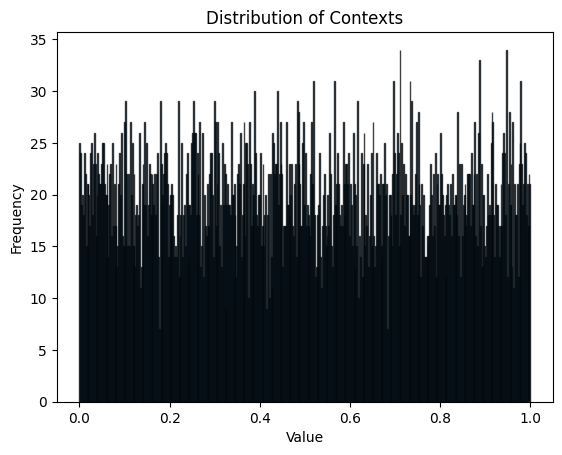

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 training_dataset 是一个包含 "contexts" 键的字典
# 这里用随机数据生成一个示例
# contexts = np.random.rand(10000)

# 获取 contexts 数据
contexts = training_dataset["contexts"]

# 绘制分布图
plt.hist(contexts, bins=500, alpha=0.75, edgecolor='black')
plt.title('Distribution of Contexts')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [8]:
statistic(training_dataset)

Pos1 -1.9952024 2.0110128
Pos2 -1.0 1.0
Pos3 -1.0 1.0
Vel1 -6.2184525 7.5548677
Vel2 -9.076932 9.396538
actions -1.0 1.0
rewards 1.8168927e-16 0.9999998
terminals 0.0 0.0
contexts 0.15022525 0.44603795


In [26]:
diffusion_dataset = np.load("./results-front/5m_samples.npz_0.2.npz")
diffusion_dataset = {key: diffusion_dataset[key] for key in diffusion_dataset.files}
statistic(diffusion_dataset)

Pos1 -2.2918906 2.1652079
Pos2 -1.0376792 1.0504538
Pos3 -1.0378847 1.0959839
Vel1 -2.7043097 4.581099
Vel2 -10.44595 8.584416
actions -1.1682864 1.1712303
rewards -0.0039991587 0.95465523
terminals 0.0 1.0


In [17]:
diffusion_dataset["observations"].shape

(2500000, 5)

In [21]:
dataset, filtered_out_daset = filter_by_boundary(training_dataset, diffusion_dataset)

In [22]:
dataset["observations"].shape

(1501307, 5)

In [7]:
statistic(diffusion_dataset)

Pos1 -2.1260161 2.3414226
Pos2 -1.0383185 0.89192533
Pos3 -1.0273024 1.1041015
Vel1 -3.2270665 4.818578
Vel2 -7.481008 6.9434156
actions -1.1899418 1.385717
rewards -0.011521127 0.6591009
terminals 0.0 1.0


In [30]:
num_range = diffusion_dataset["observations"].shape[0]
observation_loss, reward_loss = calculate_diffusion_loss(diffusion_dataset, env, num_range)

100%|██████████| 2500000/2500000 [11:55<00:00, 3492.13it/s]


In [31]:
loss = np.concatenate([observation_loss, reward_loss], axis=1)
filtered_out_indices, indices = filter_data(loss, 95)

In [17]:
dataset["observations"].shape[0]

1856536

In [24]:
statistic(training_dataset)

Pos1 -1.9777112 1.9634639
Pos2 -1.0 1.0
Pos3 -1.0 1.0
Vel1 -6.021984 5.344057
Vel2 -9.878333 9.936226
actions -0.99978125 0.99949676
rewards 0.0 0.98507845
terminals 0.0 0.0
contexts 0.100016974 0.6993948


In [25]:
statistic(diffusion_dataset)

Pos1 -2.1260161 2.3414226
Pos2 -1.0383185 0.89192533
Pos3 -1.0273024 1.1041015
Vel1 -3.2270665 4.818578
Vel2 -7.481008 6.9434156
actions -1.1899418 1.385717
rewards -0.011521127 0.6591009
terminals 0.0 1.0


In [26]:
statistic(dataset)

Pos1 -1.9708022 1.9634608
Pos2 -1.0 0.73791003
Pos3 -0.99999946 1.0
Vel1 -3.2270665 4.818578
Vel2 -7.2293296 2.3047476
actions -0.9997714 0.9994959
rewards 9.313226e-09 0.6591009
terminals 0.0 0.0


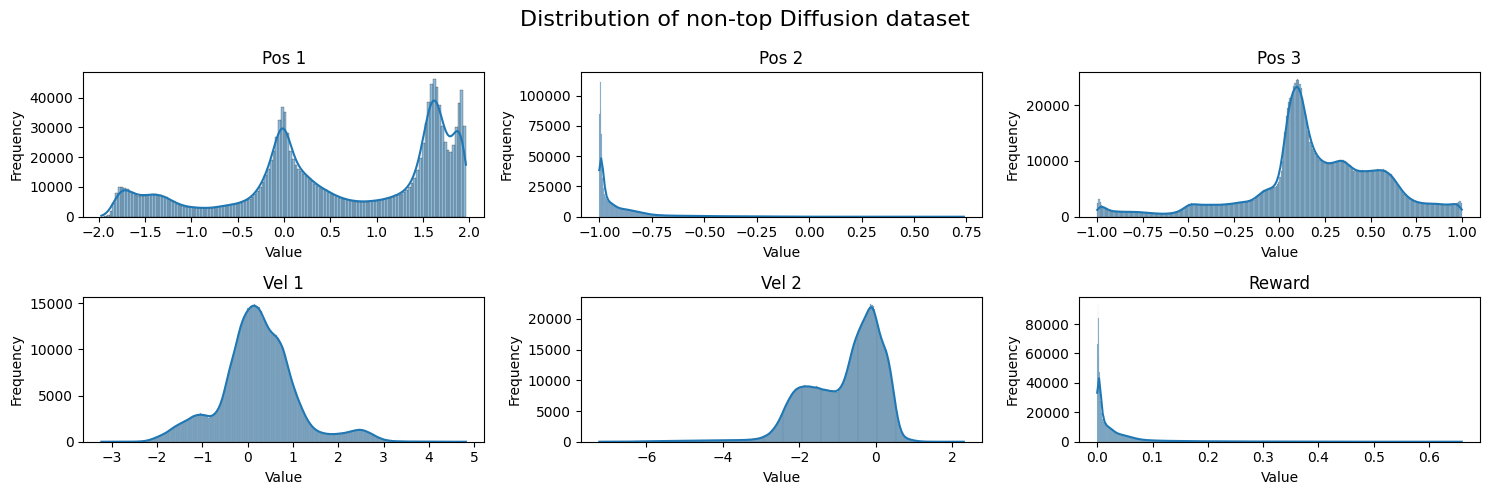

In [27]:
num_range = dataset["observations"].shape[0]
plt_distribution(dataset["observations"], dataset["rewards"], "Distribution of non-top Diffusion dataset", num_range)

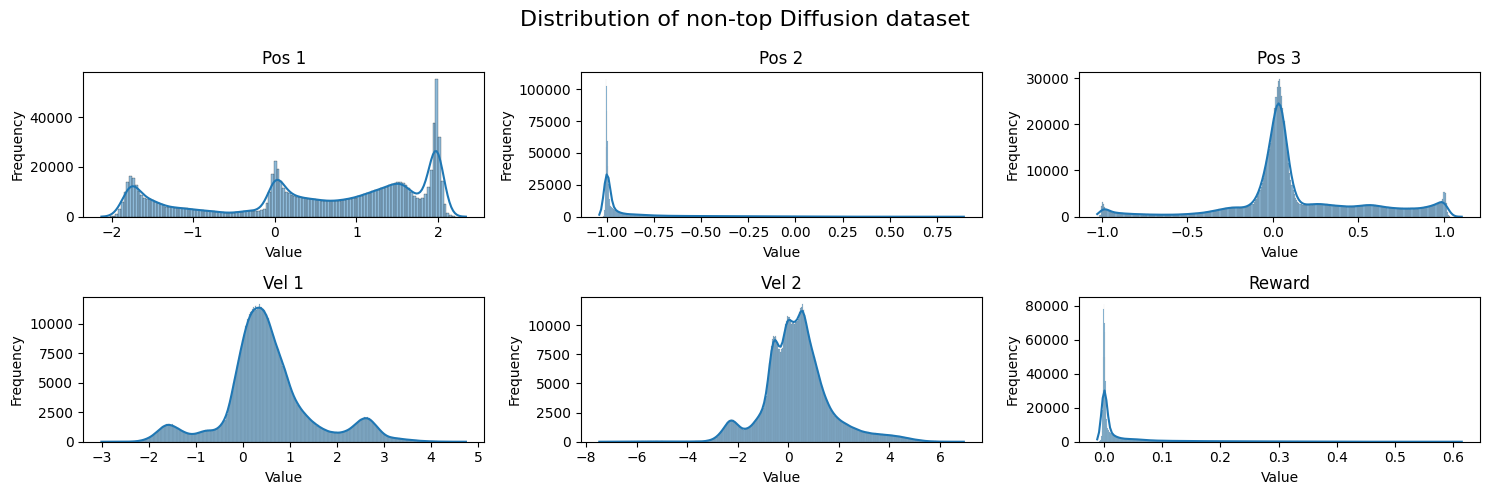

In [41]:
num_range = filtered_out_daset["observations"].shape[0]
plt_distribution(filtered_out_daset["observations"], filtered_out_daset["rewards"], "Distribution of non-top Diffusion dataset", num_range)

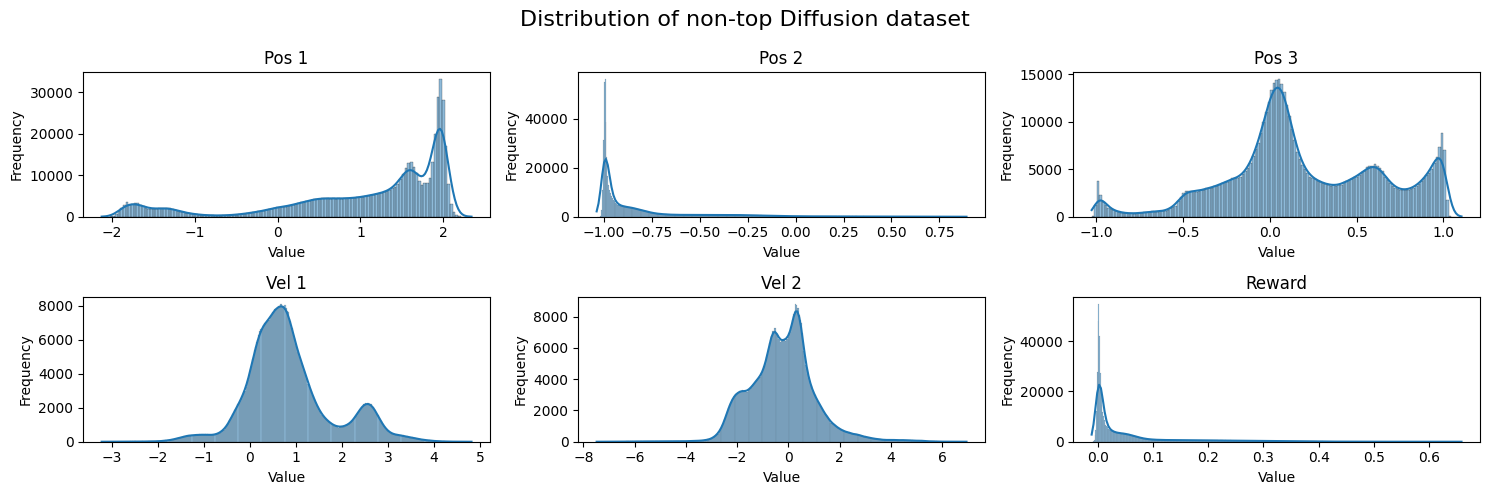

In [33]:
plt_distribution(diffusion_dataset["observations"][filtered_out_indices], diffusion_dataset["rewards"][filtered_out_indices], "Distribution of non-top Diffusion dataset", num_range)

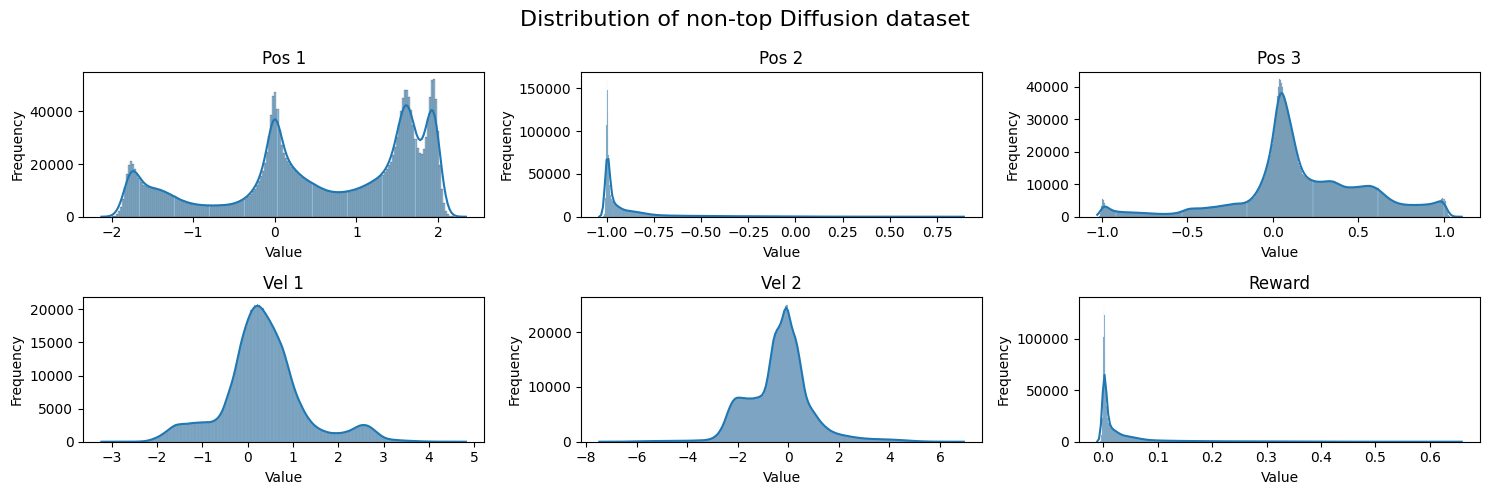

In [15]:
plt_distribution(diffusion_dataset["observations"], diffusion_dataset["rewards"], "Distribution of non-top Diffusion dataset", num_range)

In [12]:
print("reward loss mean", reward_loss.mean())
print("reward loss std", reward_loss.std())
print("reward loss max", reward_loss.max())
print("reward loss min", reward_loss.min())

reward loss mean 0.003142453416548314
reward loss std 0.0025155016885880935
reward loss max 0.020018123853555836
reward loss min 5.069848632863541e-07


In [13]:
print("observation loss mean", observation_loss.mean(axis=0))
print("observation loss std", observation_loss.std(axis=0))
print("observation loss max", observation_loss.max(axis=0))
print("observation loss min", observation_loss.min(axis=0))

observation loss mean [0.00535499 0.0069917  0.0050258  0.01644719 0.01606486]
observation loss std [0.00425932 0.00587208 0.00433017 0.02493319 0.01610252]
observation loss max [0.03545129 0.0474987  0.04996818 0.64734793 0.36089739]
observation loss min [3.35276127e-07 0.00000000e+00 4.47034836e-08 9.53674316e-07
 8.34465027e-07]


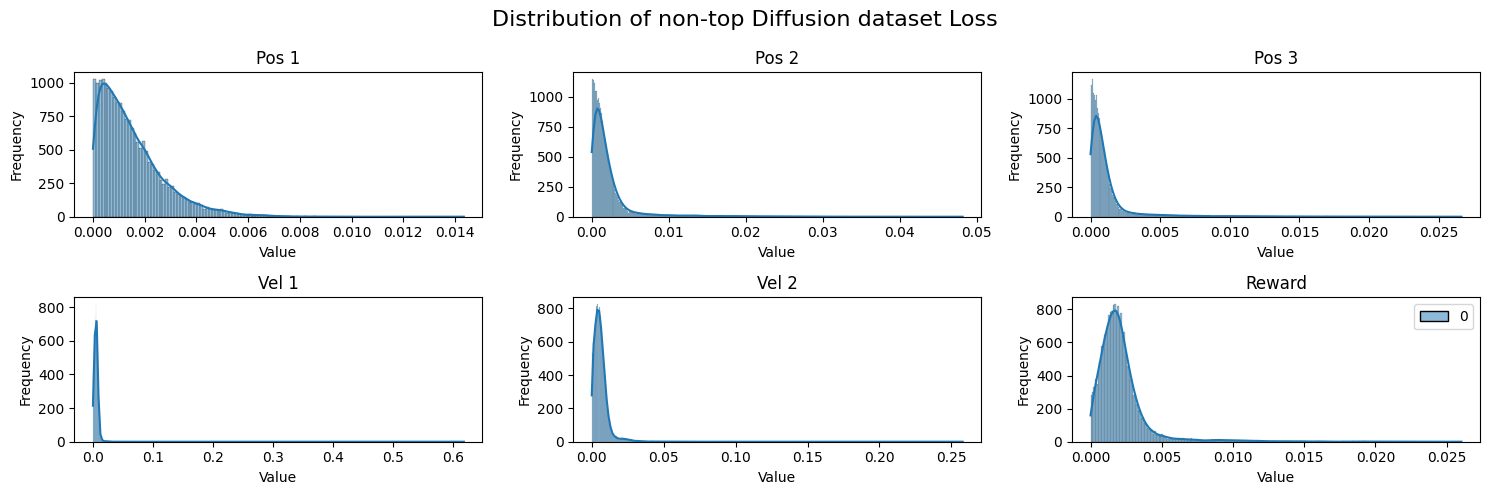

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(2, 3, figsize=(15, 5))

fig.suptitle('Distribution of non-top Diffusion dataset Loss', fontsize=16)

sns.histplot(observation_loss[:num_range, 0], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Pos 1')
axes[0, 0].set_xlabel('Value')
axes[0, 0].set_ylabel('Frequency')

sns.histplot(observation_loss[:num_range, 1], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Pos 2')
axes[0, 1].set_xlabel('Value')
axes[0, 1].set_ylabel('Frequency')

sns.histplot(observation_loss[:num_range, 2], kde=True, ax=axes[0, 2])
axes[0, 2].set_title('Pos 3')
axes[0, 2].set_xlabel('Value')
axes[0, 2].set_ylabel('Frequency')

sns.histplot(observation_loss[:num_range, 3], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Vel 1')
axes[1, 0].set_xlabel('Value')
axes[1, 0].set_ylabel('Frequency')

sns.histplot(observation_loss[:num_range, 4], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Vel 2')
axes[1, 1].set_xlabel('Value')
axes[1, 1].set_ylabel('Frequency')

sns.histplot(reward_loss[:num_range], kde=True, ax=axes[1, 2])
axes[1, 2].set_title('Reward')
axes[1, 2].set_xlabel('Value')
axes[1, 2].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

In [68]:
import numpy as np

# 示例数据
# observation_loss = np.random.rand(10000, 5)

# 计算第一列的频率分布
hist, bin_edges = np.histogram(observation_loss[:, 0], bins=200)

# 设定频率阈值，裁切掉频率低于该阈值的数据
frequency_threshold = 400

# 找到频率高于阈值的 bin
valid_bins = bin_edges[:-1][hist > frequency_threshold]

# 筛选出第一列数据在有效 bin 范围内的索引
valid_indices = np.isin(np.digitize(observation_loss[:, 0], bin_edges) - 1, np.where(hist > frequency_threshold)[0])

# 获取满足条件的索引
filtered_indices = np.where(valid_indices)

print(filtered_indices[0].shape)

(15130,)


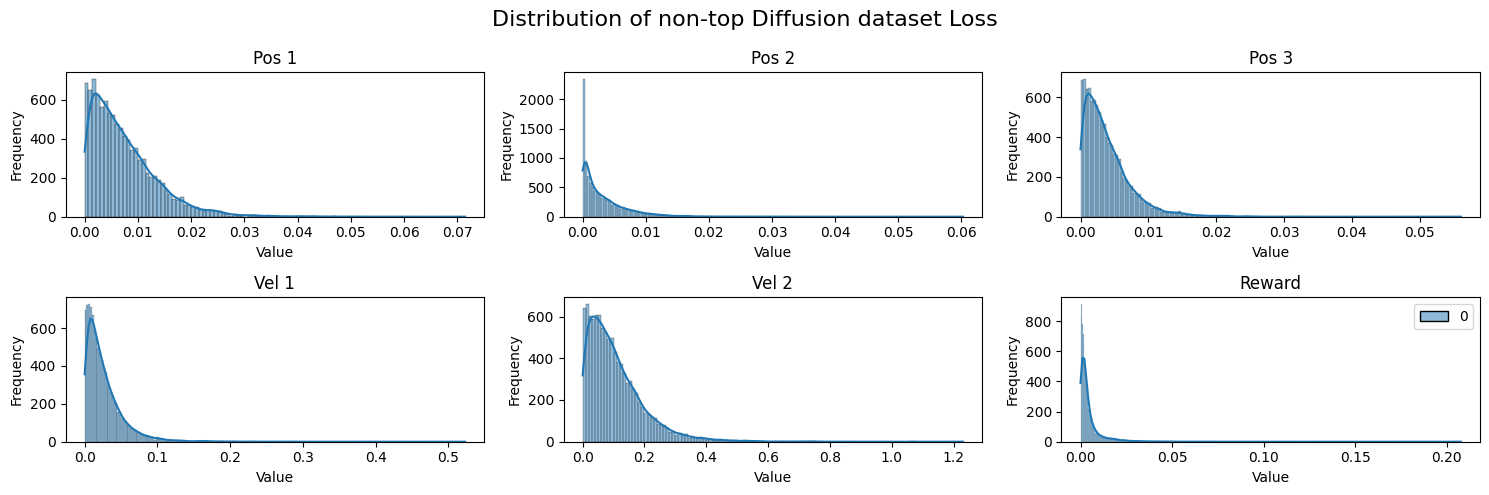

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(2, 3, figsize=(15, 5))

fig.suptitle('Distribution of non-top Diffusion dataset Loss', fontsize=16)

sns.histplot(observation_loss[:num_range, 0], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Pos 1')
axes[0, 0].set_xlabel('Value')
axes[0, 0].set_ylabel('Frequency')

sns.histplot(observation_loss[:num_range, 1], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Pos 2')
axes[0, 1].set_xlabel('Value')
axes[0, 1].set_ylabel('Frequency')

sns.histplot(observation_loss[:num_range, 2], kde=True, ax=axes[0, 2])
axes[0, 2].set_title('Pos 3')
axes[0, 2].set_xlabel('Value')
axes[0, 2].set_ylabel('Frequency')

sns.histplot(observation_loss[:num_range, 3], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Vel 1')
axes[1, 0].set_xlabel('Value')
axes[1, 0].set_ylabel('Frequency')

sns.histplot(observation_loss[:num_range, 4], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Vel 2')
axes[1, 1].set_xlabel('Value')
axes[1, 1].set_ylabel('Frequency')

sns.histplot(reward_loss[:num_range], kde=True, ax=axes[1, 2])
axes[1, 2].set_title('Reward')
axes[1, 2].set_xlabel('Value')
axes[1, 2].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

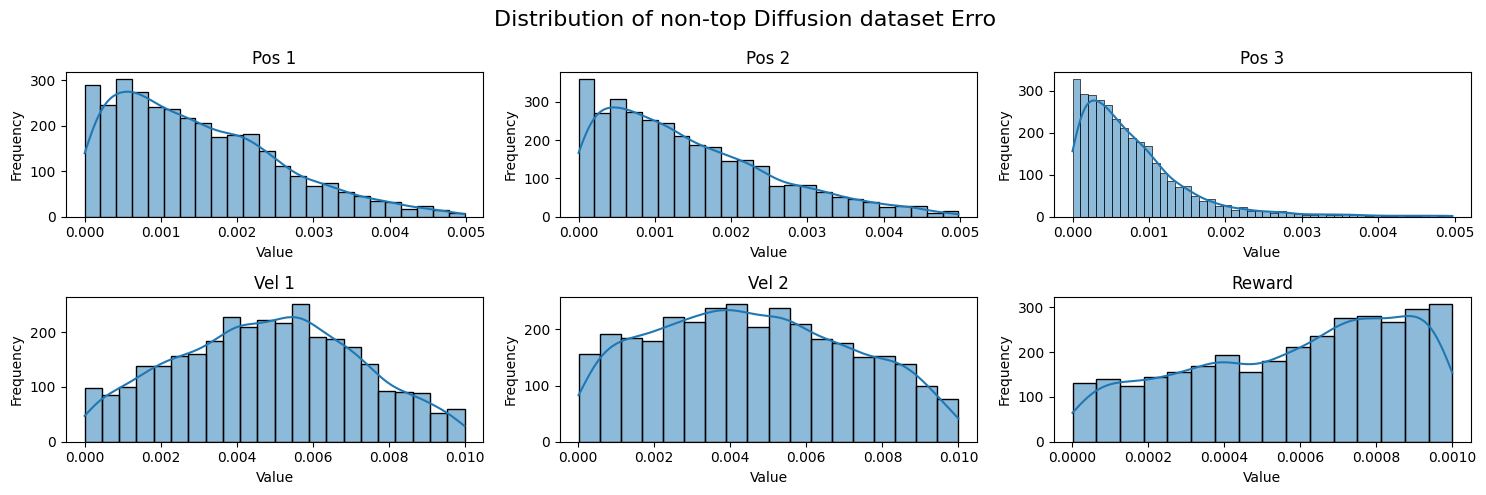

In [33]:
plt_distribution(loss[indices, 0:5], loss[indices, 5], "Distribution of non-top Diffusion dataset Erro", num_range)

In [61]:
len(indices) / len(loss)

0.1632

In [31]:
loss = np.concatenate([observation_loss, reward_loss], axis=1)
filtered_data, indices = filter_data(loss, 85)

In [9]:
num_range = 20000
numbers = np.arange(len(training_dataset["observations"]))
random_selection = np.random.choice(numbers, num_range, replace=False)

In [10]:
len(training_dataset["observations"])

54393451

In [166]:
training_dataset.keys()

dict_keys(['observations', 'actions', 'rewards', 'next_observations', 'terminals', 'contexts'])

In [149]:
import numpy as np
from collections import Counter

# 生成原始连续浮点数据
cat = np.concatenate([training_dataset["observations"], training_dataset["actions"], training_dataset["rewards"][..., None], training_dataset["next_observations"], training_dataset["terminals"][..., None], training_dataset["contexts"]], axis=1)
cat = cat[random_selection, :]
original_data = training_dataset["rewards"][random_selection]

# 将数据分桶
num_bins =100
bins = np.linspace(0, 1, num_bins + 1)
digitized = np.digitize(original_data, bins) - 1  # 将数据分配到桶中

# 计算每个桶的频率分布
data_counter = Counter(digitized)

target_frequency = max(data_counter.values())

# 根据目标频率复制数据
new_data = cat[0:1, :]
for bin_index, count in data_counter.items():
    index = np.where(digitized == bin_index)
    if count < target_frequency:
        new_data = np.concatenate([new_data, cat[np.random.choice(index[0], target_frequency, replace=True), :]], axis=0)
    else:
        new_data = np.concatenate([new_data, cat[index[0]]], axis=0)

new_data = np.array(new_data)

new_training_dataset = {}
new_training_dataset["observations"] = new_data[:, 0:5]
new_training_dataset["actions"] =  new_data[:, 5:6]
new_training_dataset["rewards"] =  new_data[:, 6]
new_training_dataset["next_observations"] =  new_data[:, 7:12]
new_training_dataset["terminals"] =  new_data[:, 12]
new_training_dataset["contexts"] =  new_data[:, 13]

775
45
37
4823
!!!
1061
270
94
427
26
66
376
29
1923
45
1977
522
39
63
131
541
311
259
33
116
176
202
177
46
38
43
165
24
38
234
228
60
183
146
27
60
255
84
251
197
45
120
104
99
75
190
44
31
330
28
188
28
38
36
37
55
36
29
167
31
183
23
149
49
53
45
33
44
50
36
18
37
31
58
25
33
45
25
28
34
46
31
26
51
28
41
36
29
91
24
33
31
85
36
32
47


In [152]:
new_training_dataset = {}
new_training_dataset["observations"] = new_data[:, 0:5]
new_training_dataset["actions"] =  new_data[:, 5:6]
new_training_dataset["rewards"] =  new_data[:, 6]
new_training_dataset["next_observations"] =  new_data[:, 7:12]
# new_training_dataset["rewards"] =  new_data[:, 12]
# new_training_dataset["rewards"] =  new_data[:, 13:15]

In [153]:
digitized = np.digitize(new_training_dataset["rewards"], bins) - 1  # 将数据分配到桶中

data_counter = Counter(digitized)

In [154]:
new_training_dataset["rewards"].shape

(482301,)

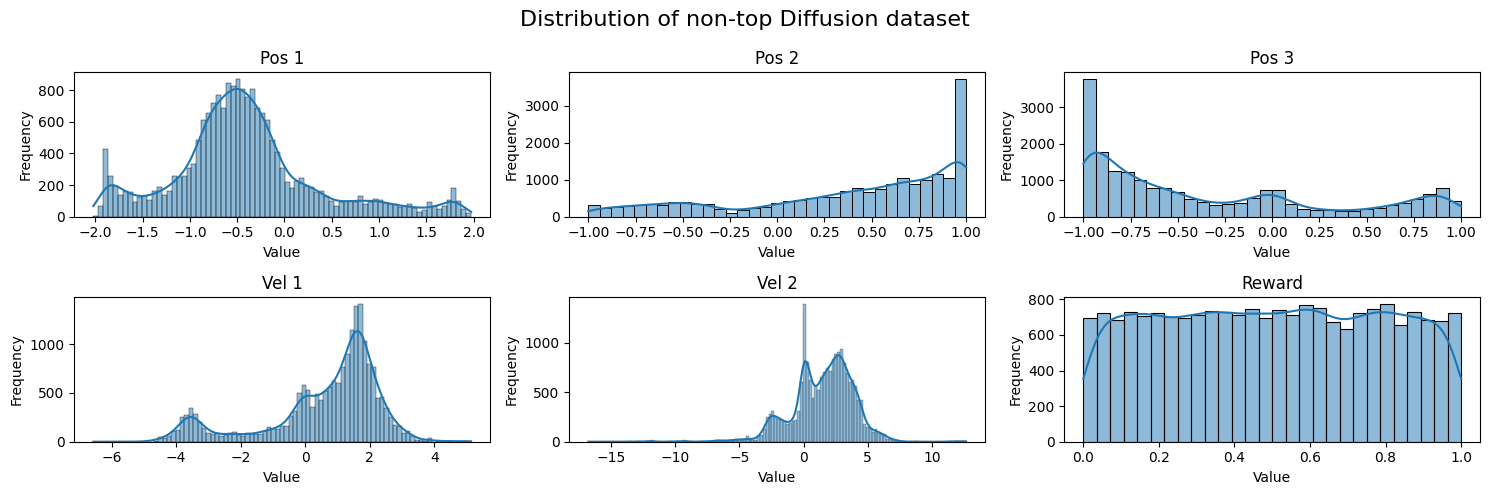

In [165]:
plt_distribution(new_training_dataset["observations"][random_selection], new_training_dataset["rewards"][random_selection], "Distribution of non-top Diffusion dataset", num_range)

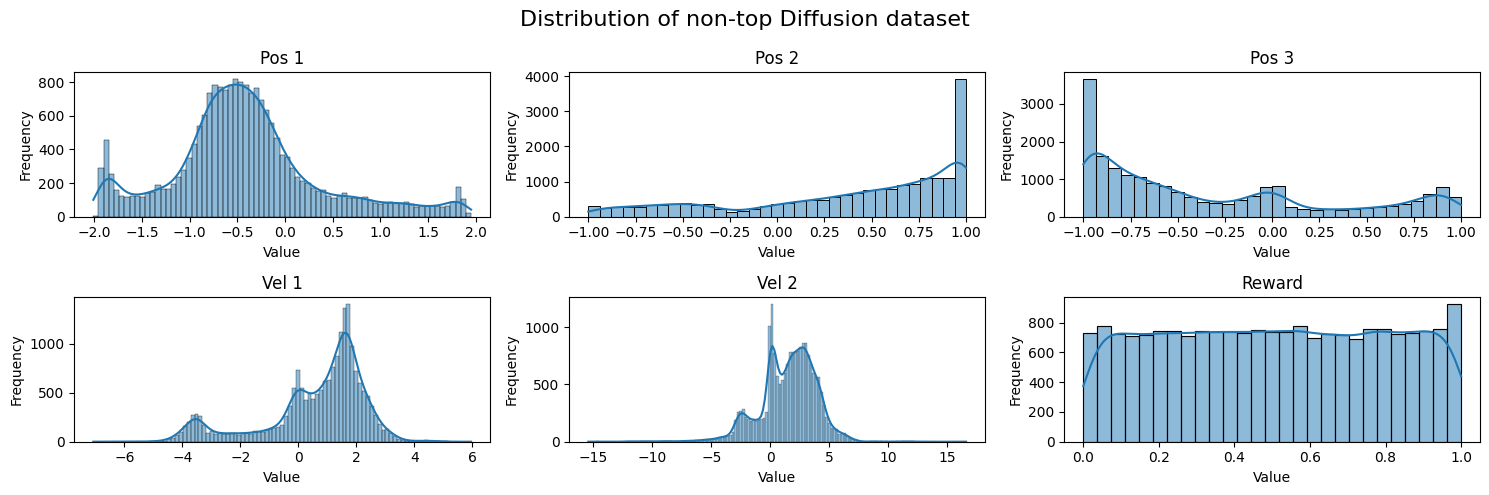

In [11]:
plt_distribution(training_dataset["observations"][random_selection], training_dataset["rewards"][random_selection], "Distribution of non-top Diffusion dataset", num_range)

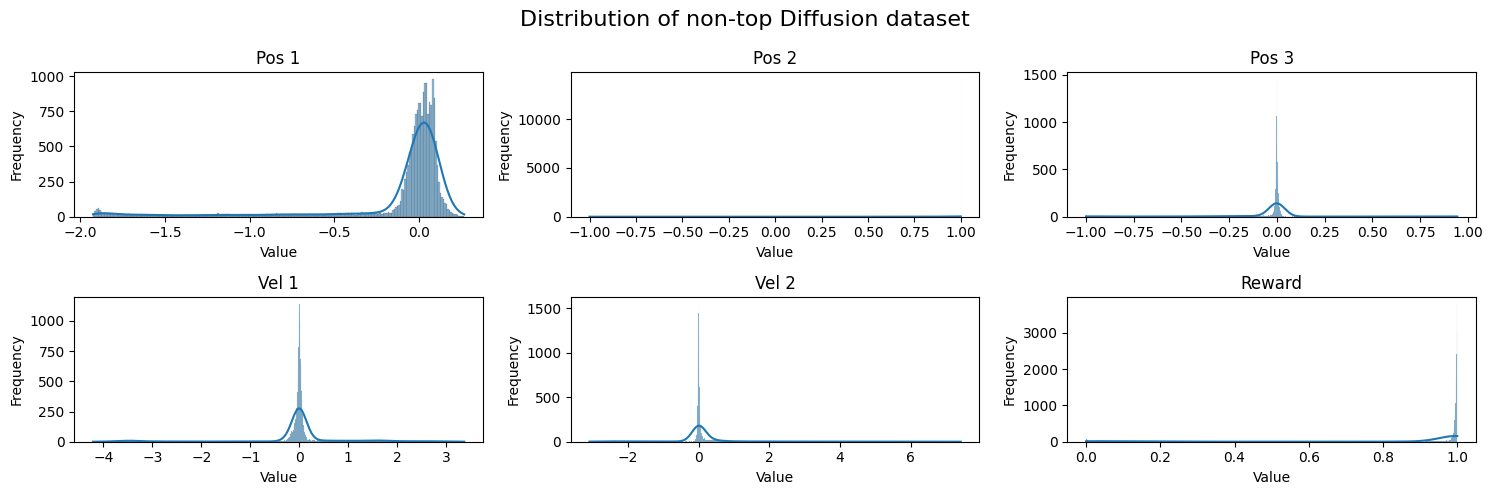

In [52]:
plt_distribution(training_dataset["observations"][random_selection], training_dataset["rewards"][random_selection], "Distribution of non-top Diffusion dataset", num_range)

In [8]:
numbers = np.arange(len(diffusion_dataset["observations"]))
random_selection = np.random.choice(numbers, num_range, replace=False)

NameError: name 'diffusion_dataset' is not defined

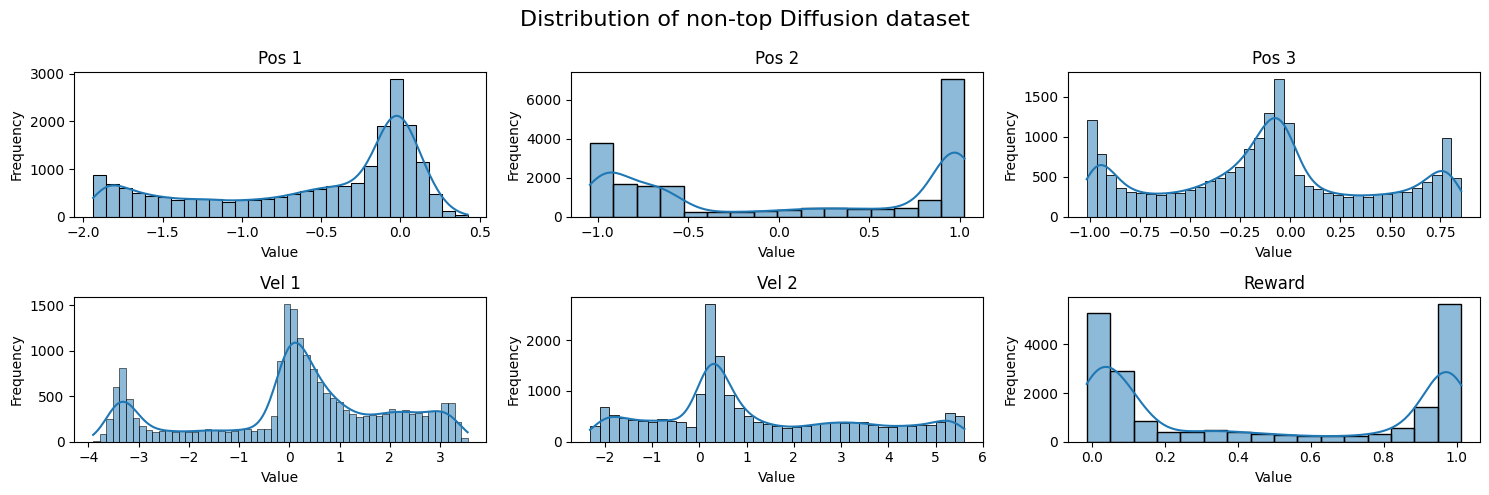

In [17]:
plt_distribution(diffusion_dataset["observations"][random_selection], diffusion_dataset["rewards"][random_selection], "Distribution of non-top Diffusion dataset", num_range)

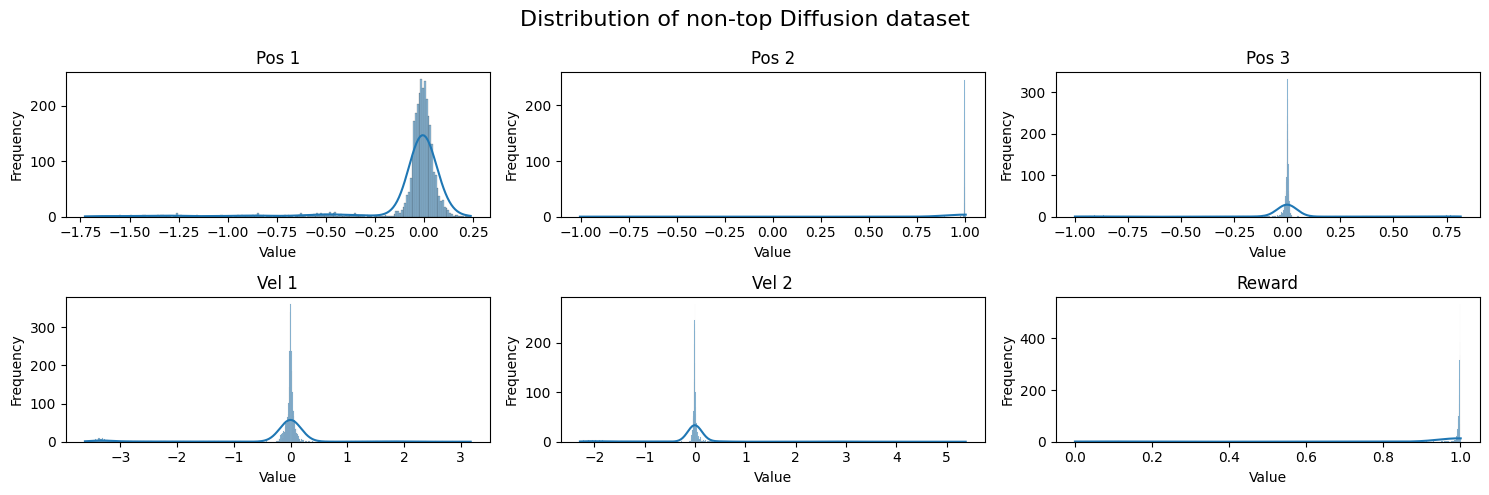

In [34]:
plt_distribution(diffusion_dataset["observations"][indices], diffusion_dataset["rewards"][indices], "Distribution of non-top Diffusion dataset", num_range)

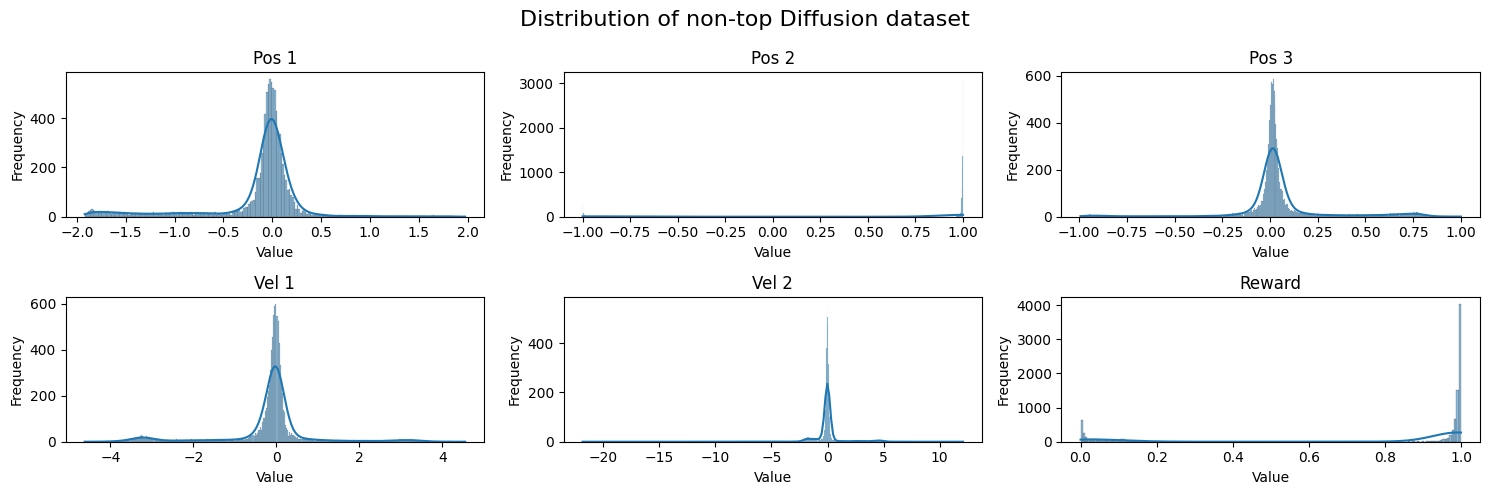

In [48]:
plt_distribution(diffusion_dataset["observations"][indices], diffusion_dataset["rewards"][indices], "Distribution of non-top Diffusion dataset", num_range)

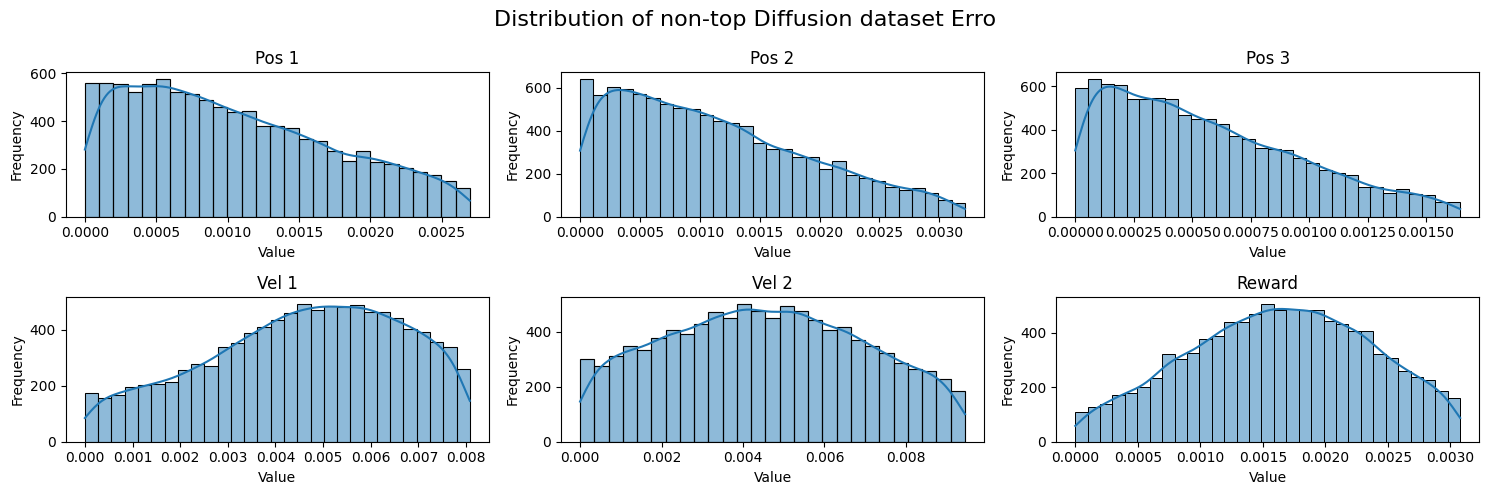

In [18]:
plt_distribution(filtered_data[:, 0:5], filtered_data[:, 5], "Distribution of non-top Diffusion dataset Erro", num_range)

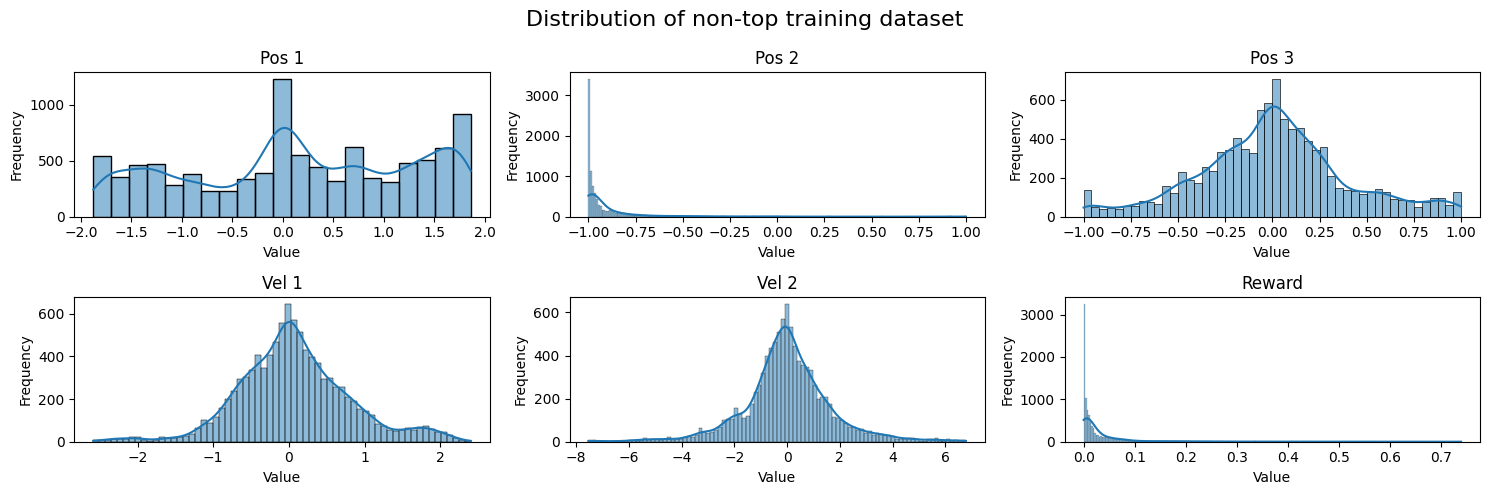

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(2, 3, figsize=(15, 5))

fig.suptitle('Distribution of non-top training dataset', fontsize=16)

sns.histplot(training_dataset["observations"][:num_range, 0], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Pos 1')
axes[0, 0].set_xlabel('Value')
axes[0, 0].set_ylabel('Frequency')

sns.histplot(training_dataset["observations"][:num_range, 1], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Pos 2')
axes[0, 1].set_xlabel('Value')
axes[0, 1].set_ylabel('Frequency')

sns.histplot(training_dataset["observations"][:num_range, 2], kde=True, ax=axes[0, 2])
axes[0, 2].set_title('Pos 3')
axes[0, 2].set_xlabel('Value')
axes[0, 2].set_ylabel('Frequency')

sns.histplot(training_dataset["observations"][:num_range, 3], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Vel 1')
axes[1, 0].set_xlabel('Value')
axes[1, 0].set_ylabel('Frequency')

sns.histplot(training_dataset["observations"][:num_range, 4], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Vel 2')
axes[1, 1].set_xlabel('Value')
axes[1, 1].set_ylabel('Frequency')

sns.histplot(training_dataset["rewards"][:num_range], kde=True, ax=axes[1, 2])
axes[1, 2].set_title('Reward')
axes[1, 2].set_xlabel('Value')
axes[1, 2].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

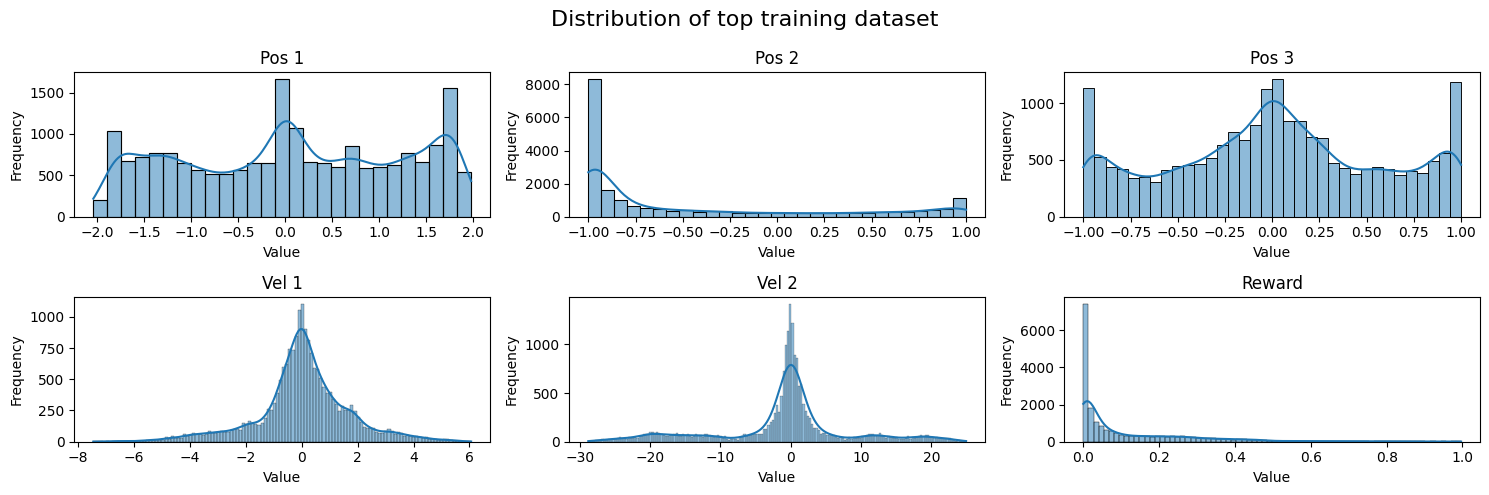

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(2, 3, figsize=(15, 5))

fig.suptitle('Distribution of top training dataset', fontsize=16)

sns.histplot(training_dataset["observations"][:num_range, 0], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Pos 1')
axes[0, 0].set_xlabel('Value')
axes[0, 0].set_ylabel('Frequency')

sns.histplot(training_dataset["observations"][:num_range, 1], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Pos 2')
axes[0, 1].set_xlabel('Value')
axes[0, 1].set_ylabel('Frequency')

sns.histplot(training_dataset["observations"][:num_range, 2], kde=True, ax=axes[0, 2])
axes[0, 2].set_title('Pos 3')
axes[0, 2].set_xlabel('Value')
axes[0, 2].set_ylabel('Frequency')

sns.histplot(training_dataset["observations"][:num_range, 3], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Vel 1')
axes[1, 0].set_xlabel('Value')
axes[1, 0].set_ylabel('Frequency')

sns.histplot(training_dataset["observations"][:num_range, 4], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Vel 2')
axes[1, 1].set_xlabel('Value')
axes[1, 1].set_ylabel('Frequency')

sns.histplot(training_dataset["rewards"][:num_range], kde=True, ax=axes[1, 2])
axes[1, 2].set_title('Reward')
axes[1, 2].set_xlabel('Value')
axes[1, 2].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

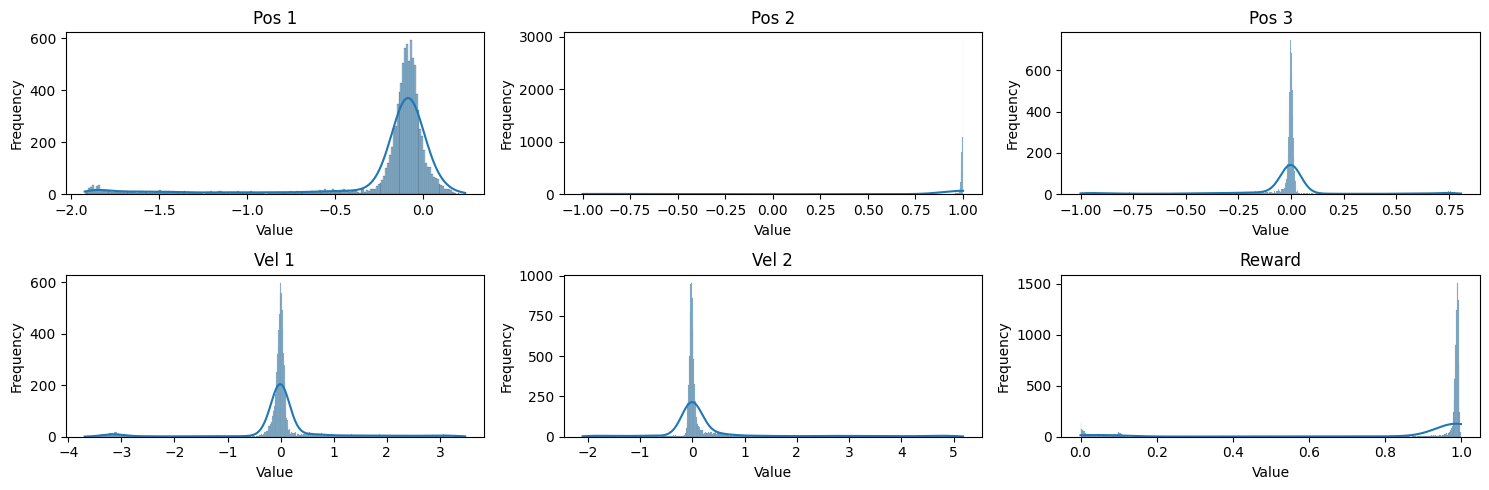

In [46]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# fig, axes = plt.subplots(2, 3, figsize=(15, 5))

# sns.histplot(diffusion_dataset["observations"][:range, 0], kde=True, ax=axes[0, 0])
# axes[0, 0].set_title('Pos 1')
# axes[0, 0].set_xlabel('Value')
# axes[0, 0].set_ylabel('Frequency')

# sns.histplot(diffusion_dataset["observations"][:range, 1], kde=True, ax=axes[0, 1])
# axes[0, 1].set_title('Pos 2')
# axes[0, 1].set_xlabel('Value')
# axes[0, 1].set_ylabel('Frequency')

# sns.histplot(diffusion_dataset["observations"][:range, 2], kde=True, ax=axes[0, 2])
# axes[0, 2].set_title('Pos 3')
# axes[0, 2].set_xlabel('Value')
# axes[0, 2].set_ylabel('Frequency')

# sns.histplot(diffusion_dataset["observations"][:range, 3], kde=True, ax=axes[1, 0])
# axes[1, 0].set_title('Vel 1')
# axes[1, 0].set_xlabel('Value')
# axes[1, 0].set_ylabel('Frequency')

# sns.histplot(diffusion_dataset["observations"][:range, 4], kde=True, ax=axes[1, 1])
# axes[1, 1].set_title('Vel 2')
# axes[1, 1].set_xlabel('Value')
# axes[1, 1].set_ylabel('Frequency')

# sns.histplot(diffusion_dataset["rewards"][:range], kde=True, ax=axes[1, 2])
# axes[1, 2].set_title('Reward')
# axes[1, 2].set_xlabel('Value')
# axes[1, 2].set_ylabel('Frequency')

# plt.tight_layout()

# plt.show()